<a href="https://colab.research.google.com/github/AnastasiaBrinati/esercizi-PMCSN-23-24/blob/main/esercizio_feedback_simulazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESERCIZIO SSQ CON FEEDBACK

####imports

In [1]:
pip install simpy

In [153]:
import simpy
import random
from typing_extensions import NamedTuple
import datetime

In [154]:
import numpy as np
from matplotlib import pyplot as plt

#### Resources

In [192]:
SIM_TIME = 1000

TIMES = {
    'arrival_times' : [],
    'waiting_times' : [],
    'service_times' : [],
    'response_times' : []
}

In [193]:
class System(NamedTuple):
    server: simpy.Resource

In [194]:
# use one random number generator to generate multiple
# “streams” of random numbers using multiple initial seeds as entry points, one for each
# stochastic system component. _leemis_chapter3

RANDOM_SEED_ARRIVI = 123456
RANDOM_SEED_FEEDBACK = 234567
RANDOM_SEED_SERVIZI = 345678

stream_arrivi = random.Random(RANDOM_SEED_ARRIVI)
stream_feedback = random.Random(RANDOM_SEED_FEEDBACK)
stream_servizi = random.Random(RANDOM_SEED_SERVIZI)

#### Fun-cs

In [195]:
# EVENTUAL FEEDBACK

def feedback():
  beta = 0.2
  r = stream_feedback.random()
  if(r <= beta):
    # job gets feed back into the system
    return 1
  # job leaves the system
  return 0

In [196]:
def job(env, id, sys):

  flag = True
  while(flag):

    arrival_at_queue = env.now
    print("job " + id + ' arrived at %f' % arrival_at_queue)

    # Enter the queue, candidates as a request for the server
    with sys.server.request() as my_turn:
      # Wait until it's our turn
      yield my_turn
      waiting_time = env.now - arrival_at_queue
      print('job ' + id +' waited for %f' % waiting_time)

      # Start the service
      print('job '+id+' starts being served at %f' % env.now)
      service_time = stream_servizi.uniform(1,2)
      yield env.timeout(service_time)
      # The service process has finished: Resource released automatically
      print('job '+id+' finished service at %f' % env.now)

      # Save some data
      TIMES['service_times'].append(service_time)
      TIMES['waiting_times'].append(waiting_time)
      TIMES['response_times'].append(waiting_time+service_time)


    if(not feedback()):
      print("job " + id + " leaving the system at %f " % env.now)
      flag = False

In [197]:
# GENERATING THE JOBS ARRIVAL FLOW

arrival_rate = 0.5

def job_arrivals(env, system):
    id = 0
    while True:
        # timeout interarrival times, waiting before generating another job
        yield env.timeout(stream_arrivi.expovariate(arrival_rate))

        # simplifying the example with fixed job size (fixed service times)
        env.process(job(env, str(id), system))
        id += 1

#### Simulation

In [ ]:
# Setup and start the simulation
env = simpy.Environment()

# Create system
system = System(
    server = simpy.Resource(env, capacity=1)
    )

# Start process and run until SIM_TIME
env.process(job_arrivals(env, system))
env.run(until=SIM_TIME)

### Analysis and Results

Avg waiting time: 11.619059 


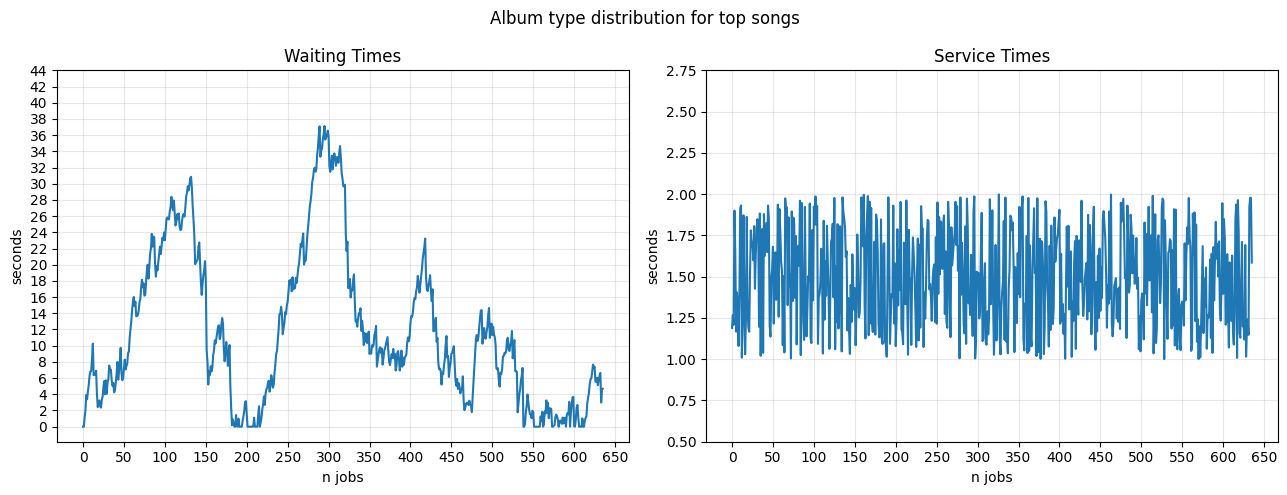

In [200]:
queuing_time_avg = sum(TIMES['waiting_times']) / len(TIMES['waiting_times'])
print("Avg waiting time: %f " % queuing_time_avg)

fig = plt.figure(figsize=(13,5))
fig.suptitle('Album type distribution for top songs');
ax = fig.subplots(nrows=1, ncols=2)

ax[0].plot(TIMES['waiting_times'])
ax[0].set_ylabel('seconds')
ax[0].set_xlabel("n jobs")
ax[0].set_yticks(np.arange(0,45,2))
ax[0].set_xticks(np.arange(0,700,50))
ax[0].set_title("Waiting Times")
ax[0].grid(alpha=0.3)

ax[1].plot(TIMES['service_times'])
ax[1].set_ylabel('seconds')
ax[1].set_xlabel("n jobs")
ax[1].set_yticks(np.arange(0.5,3,0.25))
ax[1].set_xticks(np.arange(0,700,50))
ax[1].set_title("Service Times")
ax[1].grid(alpha=0.3)

fig.tight_layout()